In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np


## CommonSense

## Goals
- Triangulate same object from different views

### Steps
1. Process one feed
1. Take a video of the empty seating space, and have it be occupied sometime during the video
1. On test video, identify a marker from the image
1. On test video, determine bounds
1. Attempt to determine occupancy from a planar 2D section

### If possible
5. Cross stitch information from two views
2. Capture visuals of the same scene from two different cameras

## 1. Process one feed

In [2]:
camera = cv2.VideoCapture(0)

In [3]:
# # starts a browser view of the default camera connected to the device
# while True:
#     ret, frame = camera.read()
#     cv2.imshow('frame', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# camera.release()
# cv2.destroyAllWindows()

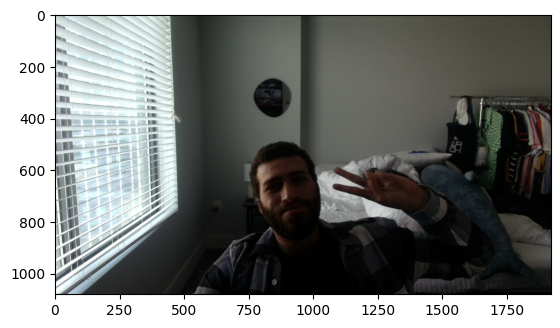

In [4]:
# get a single frame from the camera
ret, frame = camera.read()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # we convert the image to RGB 
                                                   # because matplotlib uses RGB, 
                                                   # while cv2 uses BGR

camera.release()

### 2. Work on sample images
First we read the images found in the 'frames' directory

In [5]:
#read frames from a folder
path = 'frames/'
frames = []

paths = os.listdir(path)
paths = sorted(paths, key=lambda x: int(x.split('.')[0].split('-')[1]))


for filename in paths:
    img = cv2.imread(os.path.join(path,filename))
    if img is not None:
        frames.append(img)



In [6]:
# #make mp4 video from frames
# height, width, layers = frames[0].shape
# size = (width,height)
# out = cv2.VideoWriter('video.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 30, size)

# for frame in frames:
#     for i in range(6):
#         out.write(frame)

# out.release()

To simplify computations, we can break down the checks to changes we want in a specifc bounds

In [7]:
class Bounds:
    x = 0
    y = 0
    w = 0
    h = 0

    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.h = h
        self.w = w

    def __str__(self):
        return "x: {}, y: {}, w: {}, h: {}".format(self.x, self.y, self.w, self.h)
    
    def __repr__(self):
        return "x: {}, y: {}, w: {}, h: {}".format(self.x, self.y, self.w, self.h)
    
# Determine bounds of the object

def get_bounded_image(frame, ref, bounds):
    return frame[bounds.y:bounds.y+bounds.h, bounds.x:bounds.x+bounds.w], ref[bounds.y:bounds.y+bounds.h, bounds.x:bounds.x+bounds.w]


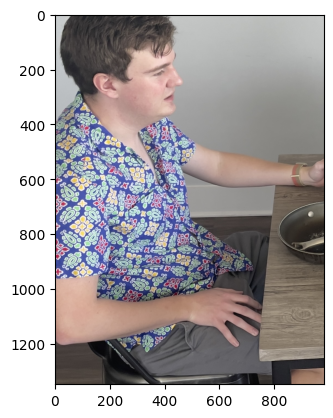

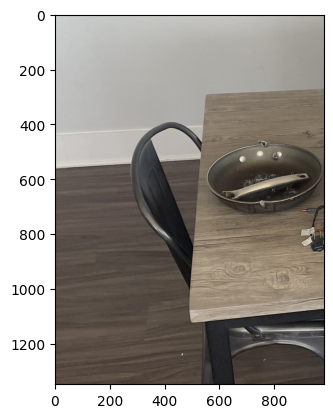

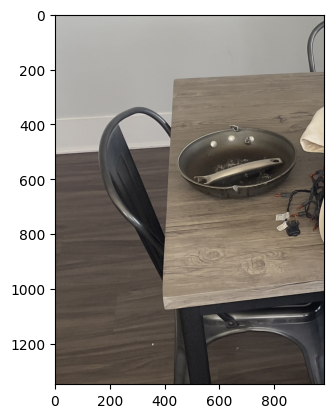

In [8]:
# First bound
bounds = Bounds(512, 908, 980, 1348)
small_im_occupied, small_ref = get_bounded_image(frames[0], frames[33], bounds)

plt.imshow(cv2.cvtColor(small_im_occupied, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(small_ref, cv2.COLOR_BGR2RGB))
plt.show()

small_im_empty, small_ref = get_bounded_image(frames[53], frames[33], bounds)

plt.imshow(cv2.cvtColor(small_im_empty, cv2.COLOR_BGR2RGB))
plt.show()
# plt.imshow(cv2.cvtColor(small_ref, cv2.COLOR_BGR2RGB))
# plt.show()

We do feature matching between the given image and the reference image

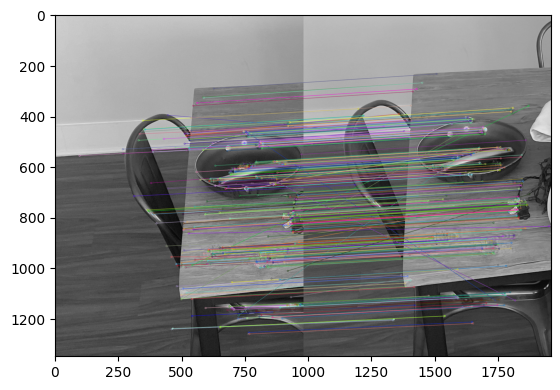

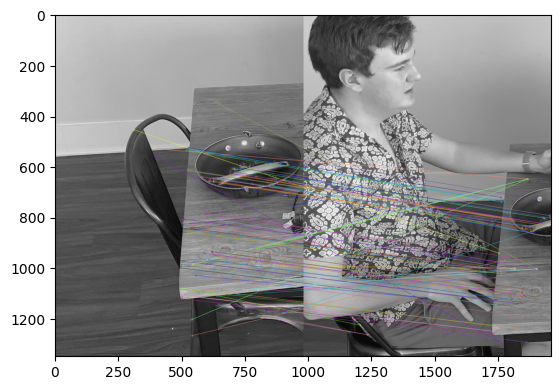

In [9]:
#align images and crop based on homography matching, first between the empty and the reference, then between the occupied and the reference

# Convert images to grayscale
small_im_occupied_gray = cv2.cvtColor(small_im_occupied, cv2.COLOR_BGR2GRAY)
small_im_empty_gray = cv2.cvtColor(small_im_empty, cv2.COLOR_BGR2GRAY)
small_ref_gray = cv2.cvtColor(small_ref, cv2.COLOR_BGR2GRAY)

# Find keypoints and descriptors
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(small_ref_gray,None)
kp2, des2 = sift.detectAndCompute(small_im_empty_gray,None)
kp3, des3 = sift.detectAndCompute(small_im_occupied_gray,None)

# Match keypoints
bf = cv2.BFMatcher()
matches1 = bf.knnMatch(des1,des2, k=2)
matches2 = bf.knnMatch(des1,des3, k=2)

# Apply ratio test
good1 = []
for m,n in matches1:
    if m.distance < 0.75*n.distance:
        good1.append([m])

good2 = []
for m,n in matches2:
    if m.distance < 0.75*n.distance:
        good2.append([m])

# Draw matches
empty_im = cv2.drawMatchesKnn(small_ref_gray,kp1,small_im_empty_gray,kp2,good1,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
occupied_im = cv2.drawMatchesKnn(small_ref_gray,kp1,small_im_occupied_gray,kp3,good2,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(empty_im)
plt.show()
plt.imshow(occupied_im)
plt.show()

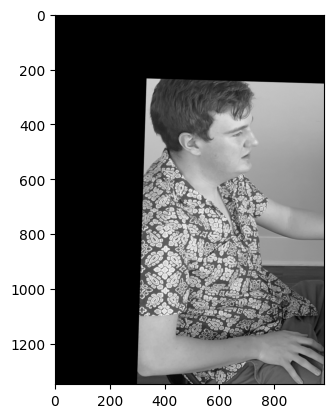

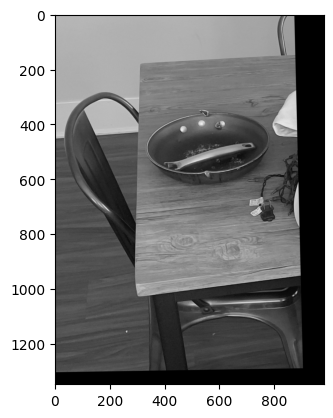

In [10]:
# using the matches, find the homography matrix
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good2 ]).reshape(-1,1,2)
dst_pts = np.float32([ kp3[m[0].trainIdx].pt for m in good2 ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,2.0)

# use the homography matrix to warp the image and crop it
h,w = small_ref_gray.shape
warped_occupied = cv2.warpPerspective(small_im_occupied_gray,M,(w,h))
warped_occupied_ref = cv2.warpPerspective(small_ref_gray,M,(w,h))

plt.imshow(cv2.cvtColor(warped_occupied, cv2.COLOR_BGR2RGB))
plt.show()

# using the matches, find the homography matrix
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good1 ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good1 ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,2.0)

# use the homography matrix to warp the image and crop it
h,w = small_ref_gray.shape
warped_empty = cv2.warpPerspective(small_im_empty_gray,M,(w,h))
warped_empty_ref = cv2.warpPerspective(small_ref_gray,M,(w,h))

plt.imshow(cv2.cvtColor(warped_empty, cv2.COLOR_BGR2RGB))

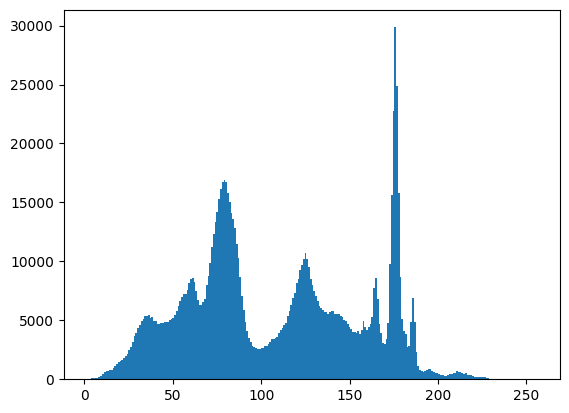

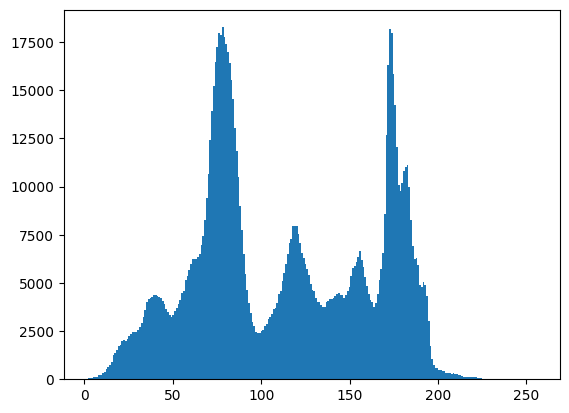

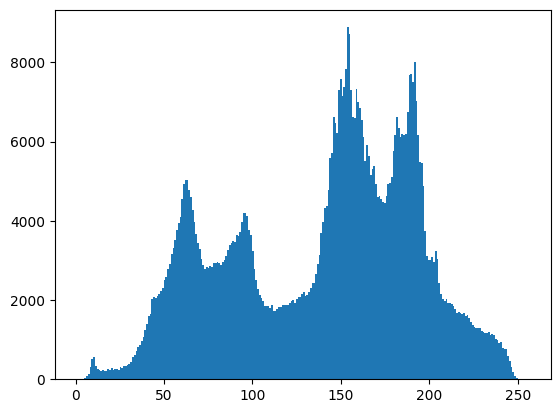

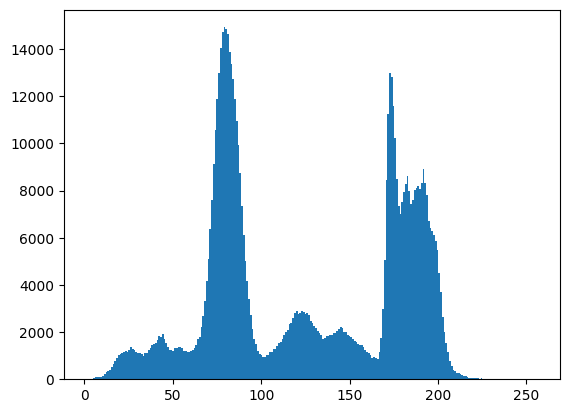

In [11]:
#compare histograms of the warped images
plt.hist(warped_empty.ravel(),256,[1,256])
plt.show()
plt.hist(warped_empty_ref.ravel(),256,[1,256])
plt.show()
plt.hist(warped_occupied.ravel(),256,[1,256])
plt.show()
plt.hist(warped_occupied_ref.ravel(),256,[1,256])
plt.show()


In [13]:
# we can also calculate the histograms
hist_empty = cv2.calcHist([warped_empty],[0],None,[256],[1,256])
hist_empty_ref = cv2.calcHist([warped_empty_ref],[0],None,[256],[1,256])
hist_occupied = cv2.calcHist([warped_occupied],[0],None,[256],[1,256])
hist_occupied_ref = cv2.calcHist([warped_occupied_ref],[0],None,[256],[1,256])

# compare the histograms with the chi-squared distance, where a smaller value means more similar
print(f"empty chi: {cv2.compareHist(hist_empty, hist_empty_ref, cv2.HISTCMP_CHISQR)}")
print(f"occupied chi: {cv2.compareHist(hist_occupied, hist_occupied_ref, cv2.HISTCMP_CHISQR)}")

# compare the histograms with the correlation distance, higher value means more similar
print(f"empty corr: {cv2.compareHist(hist_empty, hist_empty_ref, cv2.HISTCMP_CORREL)}")
print(f"occupied corr: {cv2.compareHist(hist_occupied, hist_occupied_ref, cv2.HISTCMP_CORREL)}")

# compare the histograms with the bhattacharyya distance, where a smaller value means more similar
print(f"empty bhatta: {cv2.compareHist(hist_empty, hist_empty_ref, cv2.HISTCMP_BHATTACHARYYA)}")
print(f"occupied bhatta: {cv2.compareHist(hist_occupied, hist_occupied_ref, cv2.HISTCMP_BHATTACHARYYA)}")

empty chi: 384900.67191274033
occupied chi: 857937.132644238
empty corr: 0.842764418892093
occupied corr: 0.4026411543453431
empty bhatta: 0.15863727641493036
occupied bhatta: 0.3496424959601152


We need to determine which features to use in order to differentiate between the two images, we can tell that for such drastic differences, correlation and chi-square distance are both good metrics but not the best